# Assignment 3: Classical Hough Transform

## Ex. 3.1 Detect lanes and eyes

* there are two datasets available: "images/eye_tracking" and "images/lane_detection" - decide for one of them
* implement the classical Hough Transform for lines (for lane detection) **OR** circles (eye tracking) as shown in the lecture
* use a Canny edge detector to produce edge images for the sequence of images

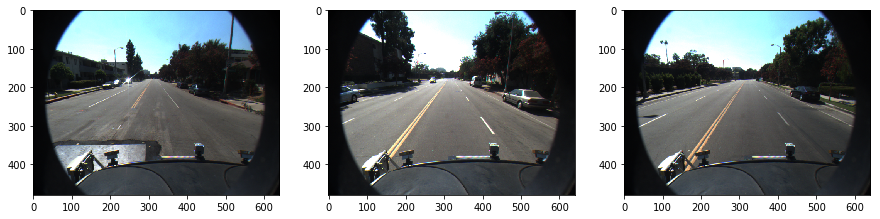

In [18]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
from scipy import ndimage as ndi
import math

#We use lane detection in this exercise

fig = plt.figure(figsize=(15, 10))
ax11 = plt.subplot(2, 3, 1)
ax12 = plt.subplot(2, 3, 2)
ax13 = plt.subplot(2, 3, 3)

lane1 = io.imread('images/lane_detection/f00000.png')
lane2 = io.imread('images/lane_detection/f00050.png')
lane3 = io.imread('images/lane_detection/f00090.png')

ax11.imshow(lane1)
ax12.imshow(lane2)
ax13.imshow(lane3)

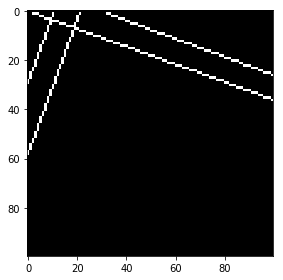

In [19]:
# dieser Code wurde als Musterlösung von Sebastian Oltmanns zur Verfügung gestellt und von Tim renoviert
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
from skimage.draw import line
from skimage import io
import math
import numpy as np

def draw_line_hessian_normal(image, a, r):
    (dimy,dimx) = image.shape
    # compute start and end point of line 
    x0 = 0
    y0 = round((r - x0 * math.cos(math.radians(a)))/math.sin(math.radians(a)))
    x1 = dimx
    y1 = round((r - x1 * math.cos(math.radians(a)))/math.sin(math.radians(a)))

    liney,linex = line(y0,x0,y1,x1)
    
    ret = np.copy(image)
    for yy in range(0,liney.size-1):
        if (liney[yy] > 0) and (liney[yy] < dimy-1):
            ret[liney[yy],linex[yy]] = 1
    return ret

image = np.zeros((100,100))
image = draw_line_hessian_normal(image, 20, 20)
image = draw_line_hessian_normal(image, 20, 10)
image = draw_line_hessian_normal(image, 110, 0)
image = draw_line_hessian_normal(image, -70, 10)
io.imshow(image)

208566 358.7242026266415 36.0


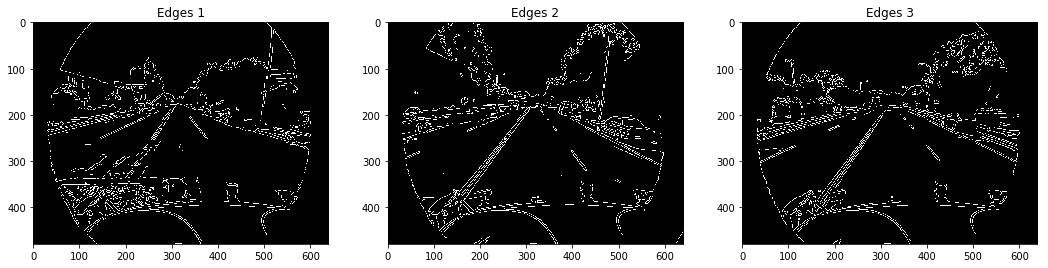

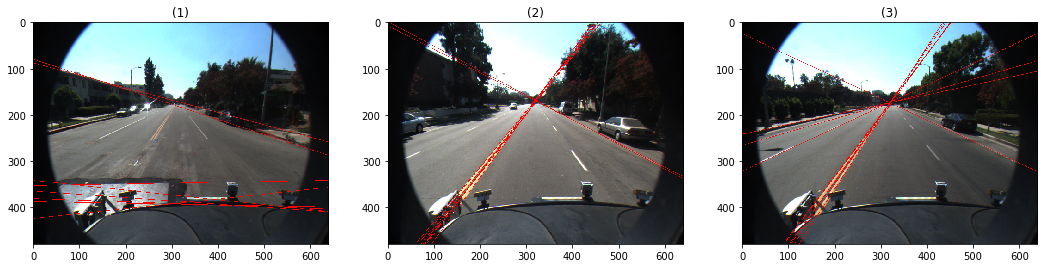

In [20]:
from math import cos, sin, radians, ceil

# produce edge images for lane images
img1 = color.rgb2gray(lane1)
lane_edges1 = feature.canny(img1)

img2 = color.rgb2gray(lane2)
lane_edges2 = feature.canny(img2)

img3 = color.rgb2gray(lane3)
lane_edges3 = feature.canny(img3)

def hough_line(img, angle_step = 1, lines_are_white = True, value_threshold = 0.4):
    
    thetas = np.deg2rad(np.arange(-90.0, 90.0, angle_step))
    width, height = img.shape
    diag_len = int(round(math.sqrt(width * width + height * height)))
    rhos = np.linspace(-diag_len, diag_len, diag_len * 2)

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)
    num_thetas = len(thetas)

    accumulator = np.zeros((2 * diag_len, num_thetas), dtype=np.uint8)
    y_idxs, x_idxs = np.nonzero(img) 
    
    are_edges = img > value_threshold if lines_are_white else img < value_threshold
    
    # Vote in the hough accumulator
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        
        for t_idx in range(num_thetas):
            rho = diag_len + int(round(x * cos_t[t_idx] + y * sin_t[t_idx]))
            accumulator[rho, t_idx] += 1

    return accumulator, thetas, rhos

def draw_hessian_normal_line(image, a, r):
    res=[]
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if r==round(x*cos(radians(a)) + y*sin(radians(a))):
                res.append((x,y))  
    x0, y0= res[0]
    x1, y1 = res[-1]
    xx, yy=line(y0, x0, y1 , x1)
    image[xx, yy] = (255,0,0) 
    return image

def find_n_local_maxima(acc, n, i = 0):
    copy = np.copy(acc) 
    combi = np.array([[0,0]]).reshape((1,2))   
    while np.size(combi) < (n*2 + 2):
        maximum = np.amax(copy)
        r, theta = np.where(copy == maximum)
        if np.size(r) > 1:
              for x in range(np.size(r)):
                    pair = np.append(r[x], theta[x]).reshape((1,2))  
                    combi = np.vstack((combi, pair))  
                    if np.size(combi) == (n*2 + 2) :
                        break
        else:
            pair = np.append(r, theta).reshape((1,2))   
            combi = np.vstack((combi, pair))  
        copy[copy == maximum] = 0
    combi = np.delete(combi, 0, 0) 
    return combi


def draw_edges_on_image(img, edges):
    accumulator, thetas, rhos = hough_line(edges)
    leng = np.hypot(img.shape[0],img.shape[1])
    leng = ceil(leng)
    combi = find_n_local_maxima(accumulator, 10)
    for x,y in combi:
        img = draw_hessian_normal_line(img, y - 90, x - leng)
    return img, accumulator

def show_images(images, titles = None):
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1, n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image, title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

accumulator, thetas, rhos = hough_line(lane_edges2)
    
idx = np.argmax(accumulator)
rho = rhos[idx // accumulator.shape[1]]
theta = thetas[idx % accumulator.shape[1]]
print(idx, rho, np.rad2deg(theta))

#idx = np.argmax(accumulator)
#rho = rhos[idx / accumulator.shape[1]]
#theta = thetas[idx % accumulator.shape[1]]

img1, acc1 = draw_edges_on_image(lane1, lane_edges1)
img2, acc2 = draw_edges_on_image(lane2, lane_edges2)
img3, acc3 = draw_edges_on_image(lane3, lane_edges3)

show_images(images = [lane_edges1, lane_edges2, lane_edges3], titles = ['Edges 1', 'Edges 2', 'Edges 3'])
show_images(images = [img1, img2, img3])

## line detection for lane detection 

* use your implementation of the Hough Transform to find the 10 strongest lines in the image
* display your result set (draw those lines on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw lines again! (**BONUS**)

## circle detection for eye detection
* use your implementation of the Hough Transform to find the 10 strongest circles in the image
* display your result set (draw those circles on the image) (**RESULT**)
* can you improve the performance by limiting the space of solutions? implement and draw circles again! (**BONUS**)

# Ex. 3.2 Generalized Hough Transform

* implement the Generalized Hough Transform as described in the lecture for localizing a given template
* find the given template (see below) and mark its location in the image "animals.png" (**RESULT**)

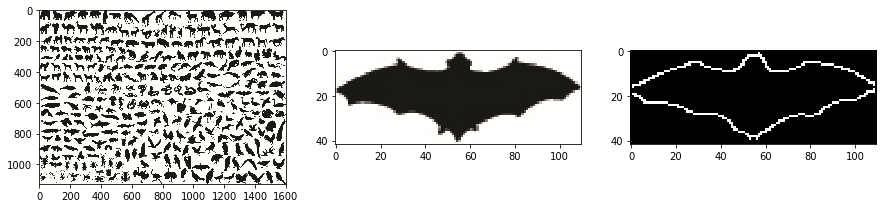

In [21]:
%matplotlib inline 
import matplotlib.pyplot as plt
from skimage import io, data, feature, color
import numpy as np
from math import cos, sin, radians, ceil

animals = io.imread('images/animals.png')

xmin = 1271
xmax = 1381
ymin = 519
ymax = 561

bat = animals[ymin:ymax, xmin:xmax]
bat_edge = feature.canny(color.rgb2gray(bat), 2)

fig = plt.figure(figsize=(15, 10))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(animals)
ax2.imshow(bat)
ax3.imshow(bat_edge)

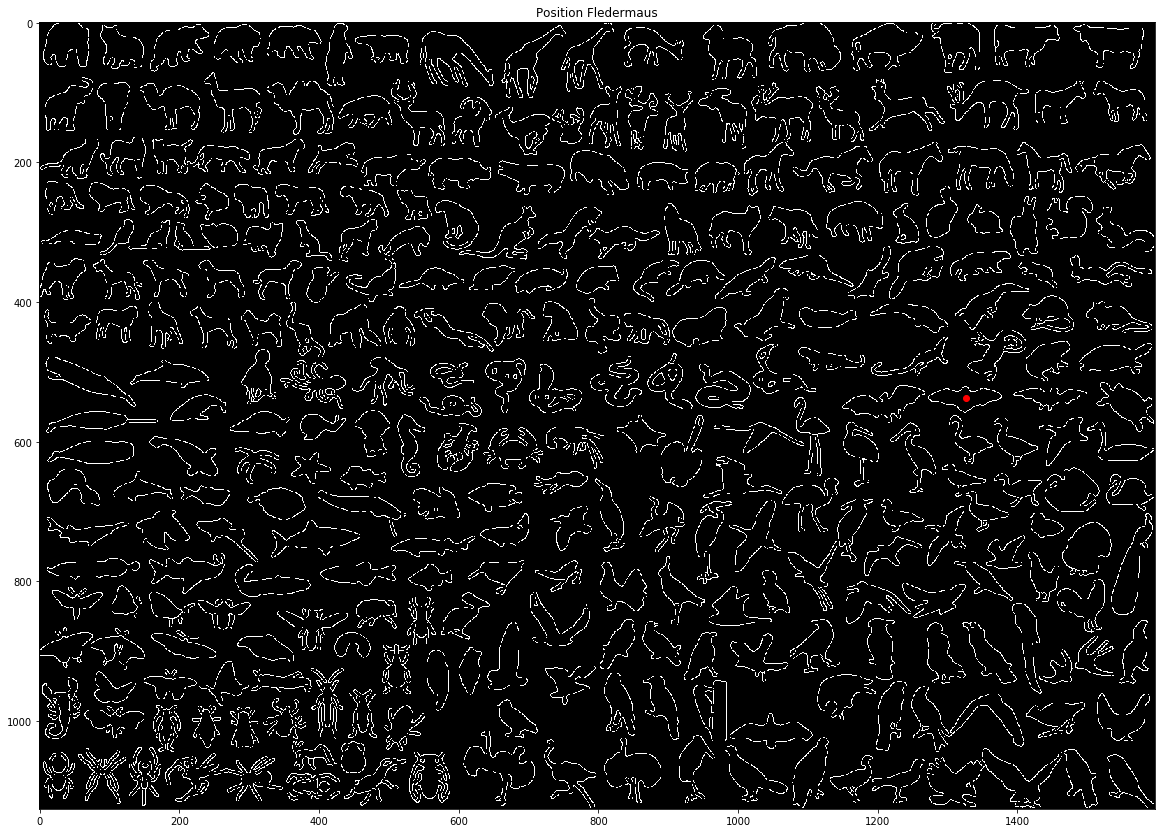

In [22]:
from scipy import ndimage, misc
from collections import defaultdict
import numpy as np
from skimage import io, data, feature, color
from scipy.ndimage.filters import sobel

def get_gradient(image):
    image_gray =color.rgb2gray(image)
    sobel_x_axis = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobel_y_axis = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    edge = feature.canny(image_gray, 2)
    sx = ndimage.convolve(edge, sobel_x_axis)
    sy = ndimage.convolve(edge, sobel_y_axis)
    gradient = np.arctan2(sy,sx)* 180 / np.pi
    return edge, gradient

def template_origin(template): 
    x0 = 0
    y0 = 0
    i = 0
    for x in range(template.shape[1]):
        for y in range(template.shape[0]): 
            if template[y, x] == True:
                x0 += x
                y0 += y
                i += 1
    xc = ceil(x0/i) 
    yc = ceil(y0/i) 
    return(yc,xc)

def create_r_table(edge, gradient, origin): 
    r_table = defaultdict(list)
    for x in range(edge.shape[1]):
        for y in range(edge.shape[0]): 
            if edge[y, x] == True:
                r = (origin[0] - y, origin[1] - x)
                r_table[gradient[y, x]].append(r) 
    return r_table


def get_accumulator(image, gradient, r_table): 
    accumulator = np.zeros(image.shape) 
    for y in range (image.shape[0]):
        for x in range(image.shape[1]): 
            if image[y,x]:
                for r in r_table[gradient[y,x]]:
                    accum_y, accum_x = y+r[0], x+r[1] 
                    if accum_y < accumulator.shape[0] and accum_x < accumulator.shape[1]:
                        accumulator[accum_y, accum_x] += 1
    return accumulator


edge, gradient = get_gradient(bat)
origin = template_origin(edge)
bat_r_table = create_r_table(edge, gradient, origin)

animals_edges, animals_gradient = get_gradient(animals)
accumulator = get_accumulator(animals_edges, animals_gradient, bat_r_table)

fig = plt.figure(figsize=(20, 15))
plt.title('Position Fledermaus')
plt.imshow(animals_edges)

i,j = np.unravel_index(accumulator.argmax(), accumulator.shape)
plt.scatter([j], [i], marker='o', color='r')
plt.show()


* now implement an extended version of the GHT that find rotated and scaled variants of the template. 
* find Italy (see "italy.jpg") and the map of Europe ("europe_map_political.gif")
* note that you can binarize your italy template by using a simple color lookup
* draw the location of italy on the map and print its scale and orientation (**BONUS**)